In [110]:
# Imports
import functools as ft
from pathlib import Path

import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.random as random
import matplotlib.pyplot as plt
import optax
from sklearn.model_selection import train_test_split
from jaxtyping import PRNGKeyArray

In [76]:
# Constants and Config
T = jnp.array(1000)
BETA_MIN = jnp.array(0.1) / T
BETA_MAX = jnp.array(20) / T

LEARNING_RATE = 1e3

key = random.PRNGKey(100)

In [74]:
# Load data
data_path = Path().absolute().parent / "superconductor"

x_files = sorted(data_path.glob("*x*.npy"))
y_files = sorted(data_path.glob("*y*.npy"))

x_data = jnp.vstack([jnp.load(file) for file in x_files])
y_data = jnp.vstack([jnp.load(file) for file in y_files])

In [80]:
# Train-Test split
# NOTE: we don't use the y for training; just want associated correctly
train_x, val_x, train_y, val_y = train_test_split(x_data, y_data, test_size=0.2, random_state=0)

In [156]:
class FullyConnectedWithTime(eqx.Module):
    """A simple model with multiple fully connected layers and some Fourier features for the time
    variable.
    """

    mlp: eqx.nn.MLP

    def __init__(self, in_size: int, key: PRNGKeyArray):
        key1, key2 = jax.random.split(key)
        self.mlp = eqx.nn.MLP(
            in_size + 4,  # Input size plus Fourier features for time
            in_size,  # Output size is the same as input size
            width_size=1024,  # Hidden layer width
            depth=2,  # Number of hidden layers
            activation=jax.nn.relu,
            key=key1,
        )

    def __call__(self, x: jnp.ndarray, t: jnp.ndarray) -> jnp.ndarray:
        t_fourier = jnp.array(
            [t - 0.5, jnp.cos(2 * jnp.pi * t), jnp.sin(2 * jnp.pi * t), -jnp.cos(4 * jnp.pi * t)]
        )
        x = jnp.concatenate([x, t_fourier])
        return self.mlp(x)


def single_loss_fn(model, weight, int_beta, data, t, key):
    mean = data * jnp.exp(-0.5 * int_beta(t))
    var = jnp.maximum(1 - jnp.exp(-int_beta(t)), 1e-5)
    std = jnp.sqrt(var)
    noise = jr.normal(key, data.shape)
    y = mean + std * noise
    pred = model(y, t)
    return weight(t) * jnp.mean((pred + noise / std) ** 2)


def batch_loss_fn(model, weight, int_beta, data, t1, key):
    batch_size = data.shape[0]
    tkey, losskey = jr.split(key)
    losskey = jr.split(losskey, batch_size)
    # Low-discrepancy sampling over t to reduce variance
    t = jr.uniform(tkey, (batch_size,), minval=0, maxval=t1 / batch_size)
    t = t + (t1 / batch_size) * jnp.arange(batch_size)
    loss_fn = ft.partial(single_loss_fn, model, weight, int_beta)
    loss_fn = jax.vmap(loss_fn)
    return jnp.mean(loss_fn(data, t, losskey))


@eqx.filter_jit
def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
    def drift(t, y, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        return -0.5 * beta * (y + model(y, t))

    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0
    y1 = jr.normal(key, data_shape)
    # reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1)
    return sol.ys[0]


def dataloader(data, batch_size, *, key):
    dataset_size = data.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        key, subkey = jr.split(key, 2)
        perm = jr.permutation(subkey, indices)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield data[batch_perm]
            start = end
            end = start + batch_size


@eqx.filter_jit
def make_step(model, weight, int_beta, data, t1, key, opt_state, opt_update):
    loss_fn = eqx.filter_value_and_grad(batch_loss_fn)
    loss, grads = loss_fn(model, weight, int_beta, data, t1, key)
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    key = jr.split(key, 1)[0]
    return loss, model, key, opt_state

In [212]:
t1=10.0
# Optimisation hyperparameters
num_steps=40_000
lr=3e-4
batch_size=256
print_every=1_000
val_every=100
# Sampling hyperparameters
dt0=0.1
sample_size=10
# Seed
seed=5678

key = jr.PRNGKey(seed)
model_key, train_key, loader_key, sample_key = jr.split(key, 4)

data = train_x
data_mean = jnp.mean(data, axis=0)
data_std = jnp.std(data, axis=0)
data_min = jnp.min(data, axis=0)
data_max = jnp.max(data, axis=0)
data = jnp.nan_to_num((data - data_mean) / data_std, nan=0.0)

val_data = jnp.nan_to_num((val_x - data_mean) / data_std, nan=0.0)

model = FullyConnectedWithTime(data.shape[1], key=model_key)
int_beta = lambda t: t  # You can experiment with other functions here
weight = lambda t: 1 - jnp.exp(-int_beta(t))  # Just chosen to upweight the region near t=0.

opt = optax.adabelief(lr)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

total_value = 0
total_size = 0
for step, data_ in zip(range(num_steps), dataloader(data, batch_size, key=loader_key)):
    value, model, train_key, opt_state = make_step(
        model, weight, int_beta, data_, t1, train_key, opt_state, opt.update
    )
    total_value += value.item()
    total_size += 1
    if (step % print_every) == 0 or step == num_steps - 1:
        key, sub_key = jr.split(key)
        val_loss = batch_loss_fn(model, weight, int_beta, val_data, t1, sub_key)

        print(
            f"Step={step:05}",
            f"Train Loss={total_value / total_size:.4f}",
            f"Val Loss={val_loss:.4f}",
            sep="\t|\t"
        )

        total_value = 0
        total_size = 0

Step=00000	|	Train Loss=1.0226	|	Val Loss=0.9978
Step=01000	|	Train Loss=0.1191	|	Val Loss=0.0878
Step=02000	|	Train Loss=0.0724	|	Val Loss=0.0680
Step=03000	|	Train Loss=0.0593	|	Val Loss=0.0568
Step=04000	|	Train Loss=0.0510	|	Val Loss=0.0500
Step=05000	|	Train Loss=0.0453	|	Val Loss=0.0436
Step=06000	|	Train Loss=0.0412	|	Val Loss=0.0410
Step=07000	|	Train Loss=0.0385	|	Val Loss=0.0384
Step=08000	|	Train Loss=0.0365	|	Val Loss=0.0368
Step=09000	|	Train Loss=0.0350	|	Val Loss=0.0349
Step=10000	|	Train Loss=0.0336	|	Val Loss=0.0340
Step=11000	|	Train Loss=0.0326	|	Val Loss=0.0326
Step=12000	|	Train Loss=0.0318	|	Val Loss=0.0323
Step=13000	|	Train Loss=0.0311	|	Val Loss=0.0317
Step=14000	|	Train Loss=0.0303	|	Val Loss=0.0304
Step=15000	|	Train Loss=0.0298	|	Val Loss=0.0307
Step=16000	|	Train Loss=0.0292	|	Val Loss=0.0303
Step=17000	|	Train Loss=0.0289	|	Val Loss=0.0294
Step=18000	|	Train Loss=0.0287	|	Val Loss=0.0291
Step=19000	|	Train Loss=0.0281	|	Val Loss=0.0288
Step=20000	|	Train L

In [215]:
key = jr.PRNGKey(seed)
model_key, train_key, loader_key, sample_key = jr.split(key, 4)
sample_key = jr.split(sample_key, sample_size**2)
sample_fn = ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(sample_key)
sample = data_mean + data_std * sample
sample = jnp.clip(sample, data_min, data_max)


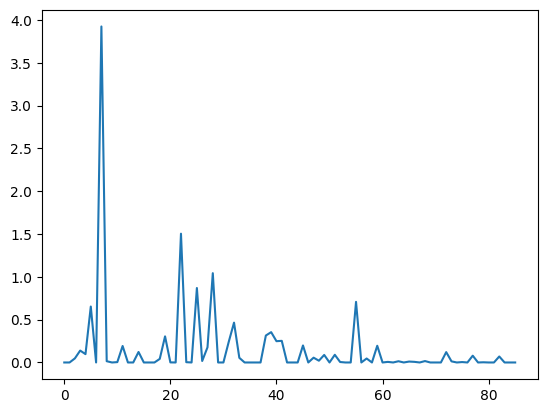

In [234]:
plt.plot(sample[2])  # Example plot for a single sample
plt.show()

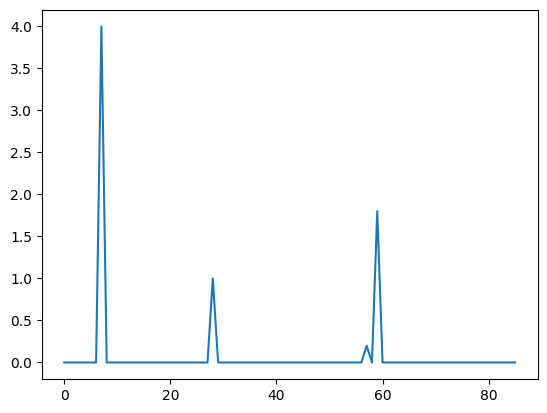

In [231]:
plt.plot(train_x[74])  # Example plot for a single sample
plt.show()